In [45]:
from numpy import pi, tan
from gpkit import Model, Variable, units
from gpkit.tools import te_exp_minus1
import gpkit
gpkit.settings['latex_modelname'] = False


class HighGasPowered(Model):
    def setup(self):
        constraints = []
        
        # Steady level flight relations
        CD = Variable('C_D', '-', 'Drag coefficient')
        CL = Variable('C_L', '-', 'Lift coefficient')
        P_shaft = Variable('P_{shaft}', 'W', 'Shaft power')
        S = Variable('S', 'm^2', 'Wing reference area')
        V = Variable('V', 'm/s', 'Cruise velocity')
        V_min = Variable('V_{min}', 10, "m/s", "minimum flight velocity")
        W = Variable('W', 'lbf', 'Aircraft weight')
        
        eta_prop = Variable(r'\eta_{prop}', 0.7, '-', 'Propulsive efficiency')
        rho = Variable(r'\rho', 'kg/m^3')

        constraints.extend([P_shaft == V*W*CD/CL/eta_prop,   # eta*P = D*V
                            W == 0.5*rho*V**2*CL*S,
                            V >= V_min])
        
        # Aerodynamics model
        Cd0 = Variable('C_{d0}', 0.01, '-', "non-wing drag coefficient")
        CLmax = Variable('C_{L-max}', 1.5, '-', 'maximum lift coefficient')
        e = Variable('e', 0.9, '-', "spanwise efficiency")
        A = Variable('A', 20, '-', "aspect ratio")
        b = Variable('b', 'ft', 'span')
        mu = Variable(r'\mu', 1.5e-5, 'N*s/m^2', "dynamic viscosity")
        Re = Variable("Re", '-', "Reynolds number")
        Cf = Variable("C_f", "-", "wing skin friction coefficient")
        Kwing = Variable("K_{wing}", 1.3, "-", "wing form factor")
        cl_16 = Variable("cl_{16}", 0.0001, "-", "profile stall coefficient")
        constraints.extend([CD >= Cd0 + 2*Cf*Kwing + CL**2/(pi*e*A) + cl_16*CL**16,
                            b**2 == S*A,
                            CL <= CLmax,
                            Re == rho*V/mu*(S/A)**0.5,
                            Cf >= 0.074/Re**0.2])
      
        # Weight model
        W_batt = Variable('W_{batt}', 'lbf', 'Battery weight')
        W_airframe = Variable('W_{airframe}', 'lbf', 'Airframe weight')
        W_eng = Variable('W_{eng}', 11.5, 'lbf', 'Engine weight')
        W_pay = Variable(r'W_{pay}', 4, 'lbf', 'Aircraft weight')
        W_fuel = Variable('W_{fuel}', 'lbf', 'Fuel Weight')
        W_zfw = Variable('W_{zfw}', 'lbf', 'Zero fuel weight')
        wl = Variable('wl', 'lbf/ft^2', 'wing loading')

        f_airframe = Variable('f_{airframe}', 0.25, '-', 'Airframe weight fraction')
        g = Variable('g', 9.81, 'm/s^2', 'Gravitational acceleration')
        
        constraints.extend([W_airframe >= W*f_airframe,
                            #W_eng >= P_shaft*0.1 * units('lbf/watt'),
                            W_zfw >= W_airframe + W_eng + W_pay,
                            wl == W/S,
                            W >= W_pay + W_eng + W_airframe + W_fuel])
            
        # Breguet Range
        z_bre = Variable("z_bre", "-", "breguet coefficient")
        h_fuel = Variable("h_{fuel}", 42e6, "J/kg", "heat of combustion")
        eta_0 = Variable("\\eta_0", 0.2, "-", "overall efficiency")
        t = Variable('t', 7, 'days', 'time on station')
        
        constraints.extend([z_bre >= g*t*V*CD/(h_fuel*eta_0*CL),
                            W_fuel/W_zfw >= te_exp_minus1(z_bre,3)])

        # Atmosphere model
        h = Variable("h", "ft", "Altitude")
        p_sl = Variable("p_{sl}", 101325, "Pa", "Pressure at sea level")
        T_sl = Variable("T_{sl}", 288.15, "K", "Temperature at sea level")
        L_atm = Variable("L_{atm}", 0.0065, "K/m", "Temperature lapse rate")
        T_atm = Variable("T_{atm}", "K", "air temperature")
        M_atm = Variable("M_{atm}", 0.0289644, "kg/mol", "Molar mass of dry air")
        R_atm = Variable("R_{atm}", 8.31447, "J/mol/K")
        TH = (g*M_atm/R_atm/L_atm).value.magnitude  # dimensionless
        constraints.extend([h <= 20000*units.m,  # Model valid to top of troposphere
                            T_sl >= T_atm + L_atm*h,     # Temp decreases w/ altitude
                            rho <= p_sl*T_atm**(TH-1)*M_atm/R_atm/(T_sl**TH)])  # http://en.wikipedia.org/wiki/Density_of_air#Altitude
        
        # station keeping requirement
        footprint = Variable("d_{footprint}", 100, 'km', "station keeping footprint diameter")
        lu = Variable(r"\theta_{look-up}", 5, '-', "look up angle")
        R_earth = Variable("R_{earth}", 6371, "km", "Radius of earth")
        tan_lu = lu*pi/180. + (lu*pi/180.)**3/3.  # Taylor series expansion
        # approximate earth curvature penalty as distance^2/(2*Re)
        constraints.extend([h >= tan_lu*0.5*footprint + footprint**2/8./R_earth])

        objective = W
        
        return objective, constraints

m = HighGasPowered()
sol = m.solve()


Using solver 'cvxopt'
Solving for 17 variables.
Solving took 0.0162 seconds.

Cost
----
 32.08 [lbf] 

Free Variables
--------------
         C_D : 0.04715                Drag coefficient              
         C_L : 1.072                  Lift coefficient              
         C_f : 0.006358               wing skin friction coefficient
   P_{shaft} : 89.68      [W]         Shaft power                   
          Re : 2.136e+05              Reynolds number               
           S : 3.454      [m**2]      Wing reference area           
     T_{atm} : 258.4      [K]         air temperature               
           V : 10         [m/s]       Cruise velocity               
           W : 32.08      [lbf]       Aircraft weight               
W_{airframe} : 8.02       [lbf]       Airframe weight               
    W_{fuel} : 8.561      [lbf]       Fuel Weight                   
     W_{zfw} : 23.52      [lbf]       Zero fuel weight              
        \rho : 0.7708     [kg/m**3]    

In [43]:
sol("W")

39.3126792248488

In [26]:
import numpy as np
m.substitutions.update({"d_{footprint}": ('sweep', np.linspace(100, 300, 13)),
                        "h_{batt}": ('sweep', np.linspace(150, 250, 13))})
sol = m.solve(solver="mosek", verbosity=0, skipsweepfailures=True)

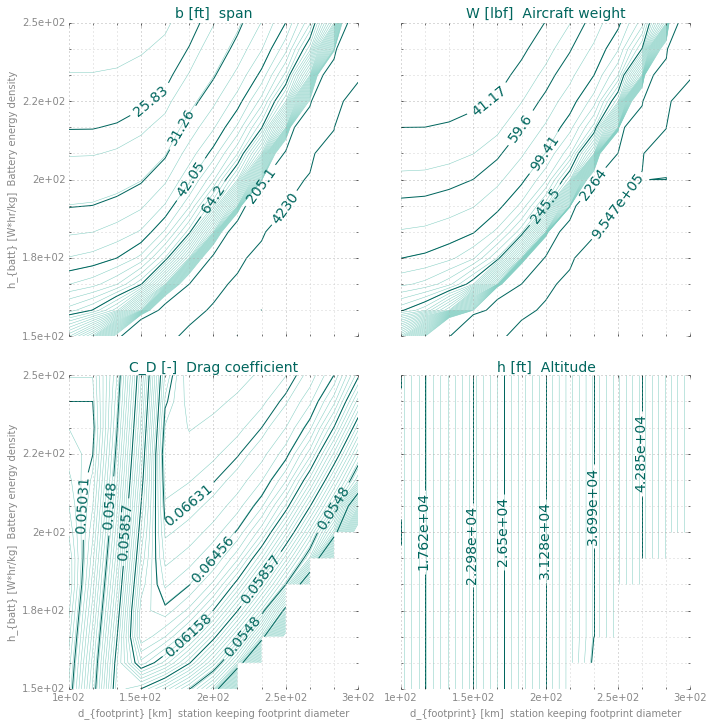

In [27]:
%matplotlib inline
from gpkit.interactive.plotting import contour_array
_ = contour_array(m, "d_{footprint}", "h_{batt}", ["b", "W", "C_D", "h"])